# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# EDA

In [2]:
df = pd.read_csv('./data/large_train_sample.csv')

In [3]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

In [4]:
df.wage.unique()
wage_dict = {
    ' >50K': 1,
    ' <=50K': 0
}

df.wage = df.wage.map(wage_dict)

In [5]:
sex_dict = {
    ' Female': 1, 
    ' Male': 0
}

df.sex.unique()
df.sex = df.sex.map(sex_dict)

In [6]:
df['marital-status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

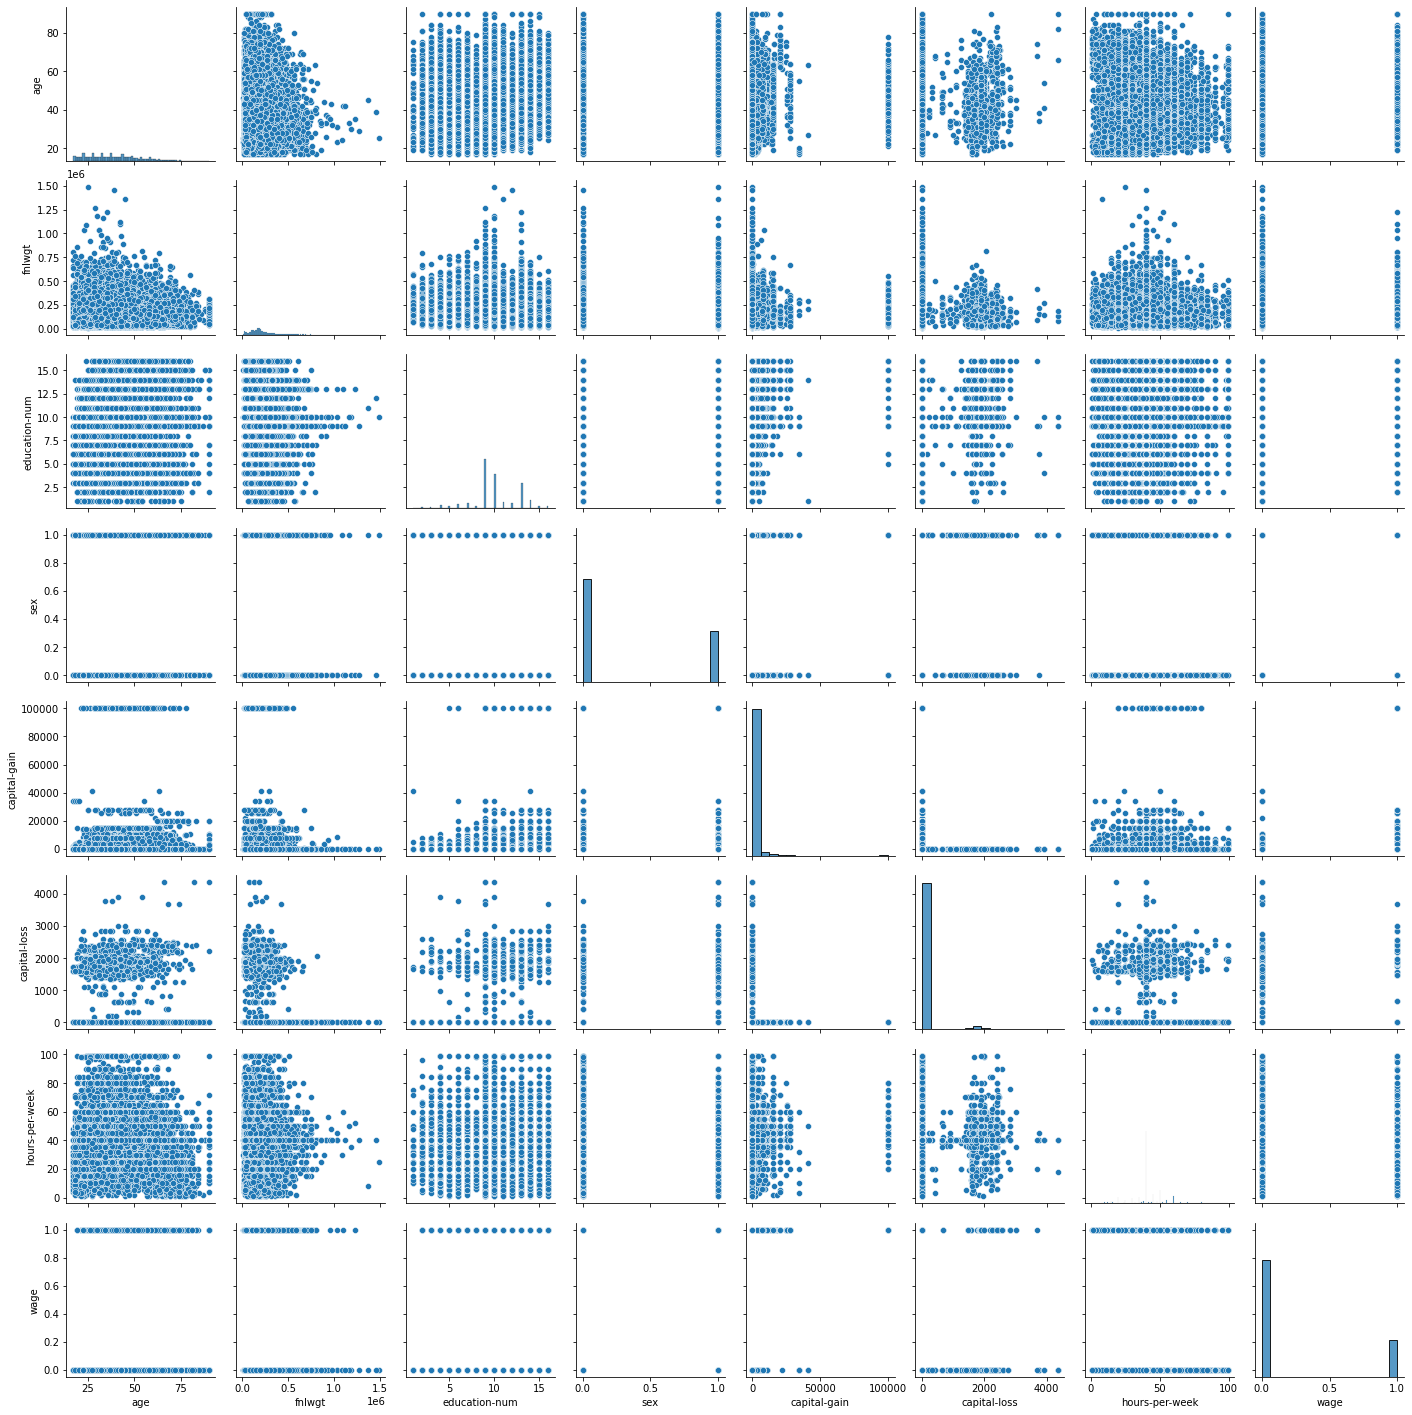

In [7]:
sns.pairplot(df);

In [9]:
df['marital-status'].unique()
df._get_numeric_data().columns

df = pd.get_dummies(df, columns = ['marital-status'], drop_first = True)

In [10]:
df._get_numeric_data().shape

(32561, 14)

# Modeling

In [11]:
# baseline
df.wage.value_counts(normalize = True)

# must get a score better than .75919

0    0.75919
1    0.24081
Name: wage, dtype: float64

In [12]:
# set up X and y

features = df._get_numeric_data().columns.drop(['wage', 'fnlwgt'])
X = df[features]
y = df.wage

In [13]:
# set up scaled X

ss = StandardScaler()
Xs = ss.fit_transform(X)

## Logistic Regression

### No Standard Scaler

In [14]:
logr = LogisticRegression()

cross_val_score(logr, X, y, cv = 5, n_jobs = -1).mean()

# returns 0.8208899202162676

0.8208899202162676

### Standard Scaler

In [15]:
logr = LogisticRegression()

# logr.fit(X_train, y_train)

cross_val_score(logr, Xs, y, cv = 5, n_jobs = -1).mean()

# returns 0.8421119111238872

0.8421119111238872

## Random Forest

### Grid Search for Best Parameters

In [16]:
rf = RandomForestClassifier()

rf_params = {
    'max_depth': list(range(5,10,2)),
    'n_estimators': [75, 100, 150, 200],
    'max_features': ['auto', 'log2']
}

grid = GridSearchCV(rf, param_grid=rf_params, n_jobs = -1, cv = 5, verbose =1)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

# {'max_depth': 9, 'max_features': 'log2', 'n_estimators': 150}
# 0.8580512335751858

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.5min finished


{'max_depth': 9, 'max_features': 'log2', 'n_estimators': 200}
0.8582354946127401


### No Standard Scaler using best params

In [32]:
rf = RandomForestClassifier(n_estimators=150, max_features='log2', max_depth=9)

cross_val_score(rf, X, y, cv = 5, n_jobs = -1, verbose =1).mean()

# returns 0.858143352305029

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


0.8577748490922144

### Standard Scaler using best params

In [18]:
rf = RandomForestClassifier(n_estimators=150, max_features='log2', max_depth=9)

cross_val_score(rf, Xs, y, cv = 5, n_jobs = -1, verbose =1).mean()

# returns 0.8575905408989242

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


0.8578669913999255

## AdaBoost

### No Standard Scaler

In [19]:
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=150, 
                                                               max_features='log2', 
                                                               max_depth=9))

cross_val_score(ada, X, y, cv = 5, n_jobs = -1, verbose = 1).mean()

# returns 0.8548878853519574

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.2min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.2min finished


0.8548878853519574

### Standard Scaler

In [20]:
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier(
    n_estimators=150, max_features='log2', max_depth=9))

cross_val_score(ada, Xs, y, cv=5, n_jobs=-1, verbose=1).mean()

# returns 0.8551335573042159

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.6min remaining: 11.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.7min finished


0.8551335573042159

# Get submission data

In [63]:
def get_pred_probs(train, test):
    
# get mapped/dummied values
    
    sex_dict = {
    ' Female': 1, 
    ' Male': 0
    }
    
    wage_dict = {
        ' >50K': 1,
        ' <=50K': 0
    }
    
    train.sex = train.sex.map(sex_dict)
    train.wage = train.wage.map(wage_dict)
    test.sex = test.sex.map(sex_dict)
    
    train = pd.get_dummies(train, columns = ['marital-status'], drop_first = True)
    test = pd.get_dummies(test, columns = ['marital-status'], drop_first = True)
    
# set up X, y on train, and X on test

    features = train._get_numeric_data().columns.drop(['wage', 'fnlwgt'])
    train_X = train[features]
    y = train.wage
    test_X = test[features]
    
# instaniate Random Forest, fit random forest to training data

    rf = RandomForestClassifier(n_estimators=150, max_features='log2', max_depth=9)
    rf.fit(train_X, y)
    
# get predicted probabilities 
    
    submission_probs = pd.DataFrame()
    submission_probs['wage'] = pd.DataFrame(rf.predict_proba(test_X))[1]
#     submission_probs = 
    
    return submission_probs

In [65]:
train = pd.read_csv('./data/large_train_sample.csv')
test = pd.read_csv('./data/test_data.csv')

submit = get_pred_probs(train, test)

In [66]:
submit.to_csv('./submission.csv', index = False)